# Interpretation
## Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

sns.set_palette("colorblind")
sns.set_style("whitegrid")

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
#dataset = "initial"
dataset = "final2"

filenames = glob.glob(f"data/{dataset}/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [3]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)


In [4]:
df.Algorithm[df.Algorithm == "parallel sollin FAL"] = "Sollin FAL"
df.Algorithm[df.Algorithm == "parallel sollin AL"] = "Sollin AL"
df.Algorithm[df.Algorithm == "Sequential Kruskal"] = "Kruskal"
df.Algorithm[df.Algorithm == "Boost DenseBoruvska"] = "BGL: Dense Boruvka"
df.Algorithm[df.Algorithm == "Boost MergeLocal"] = "BGL: Local merge"
df.Algorithm[df.Algorithm == "Boost BoruvkaThenMerge"] = "BGL: Boruvka then merge"
df.Algorithm[df.Algorithm == "Boost BoruvkaMixedMerge"] = "BGL: Boruvka mixed merge"

df["Graph_name"][df["Graph_name"] == "USA-road-t."] = "USA-road-d."

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/

In [5]:
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]
df['speedup'] = df.apply(lambda x: df[(df.Algorithm == x.Algorithm) & (df.Graph == x.Graph) & (df['Max threads'] == 1)].time.median() / x.time, 1)

In [6]:
s = df[["Algorithm", "Graph", "Max threads", "speedup", "time"]]\
    .groupby(("Graph", "Algorithm", "Max threads"))\
    .agg(["median", "std"])
s.time.to_csv(f"summaries/{dataset}/time_summary.csv")
s.time.to_latex(f"summaries/{dataset}/time_summary.tex")
s.speedup.to_csv(f"summaries/{dataset}/speedup_summary.csv")
s.speedup.to_latex(f"summaries/{dataset}/speedup_summary.tex")

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [7]:
todrop18 = [("Preferential attachment 100 edges per vertice", 1000), ("Preferential attachment 20 edges per vertice", 2000)]
df = df[ (~ df.Graph.isin(todrop18)) | (df['Max threads'] <= 18)]

todrop = [("Preferential attachment 100 edges per vertice", 10000)]
df = df[~ df.Graph.isin(todrop)]

In [8]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [9]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

## Graphs

In [10]:
from copy import deepcopy
df_base = deepcopy(df[df.Graph.isin(todrop18)])
df_oth = deepcopy(df[~df.Graph.isin(todrop18)])

df_base['Algorithm'] = df_base['Algorithm'].cat.remove_unused_categories()
df_oth['Algorithm'] = df_oth['Algorithm'].cat.remove_unused_categories()

### Speedups

### Runtimes

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


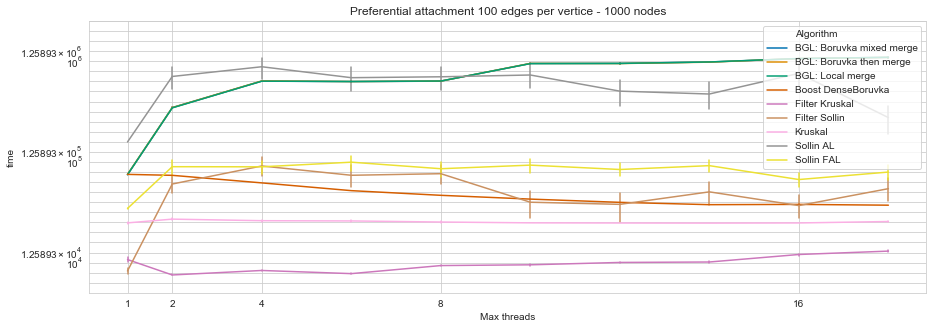

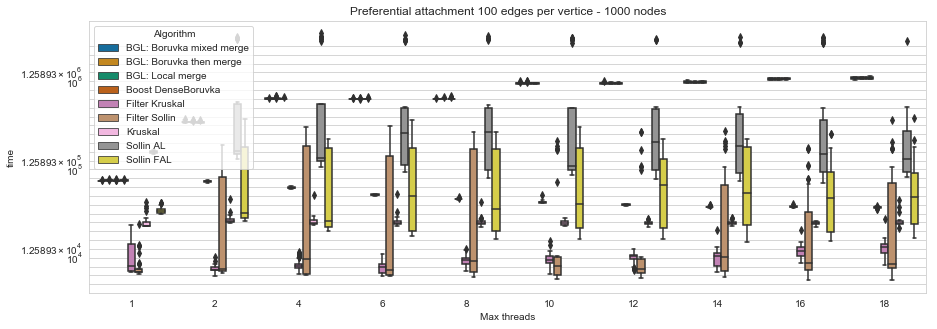

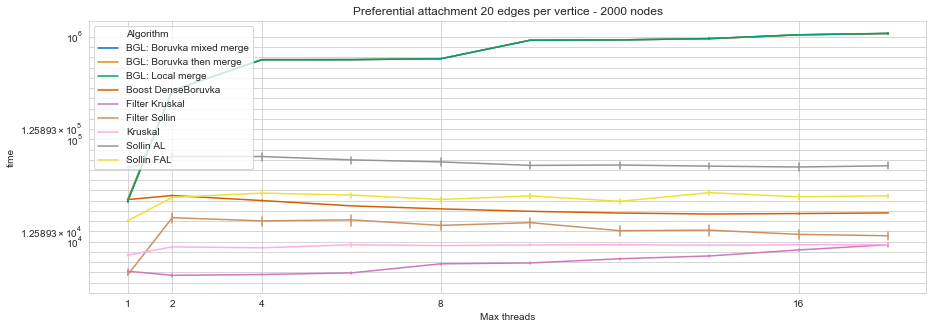

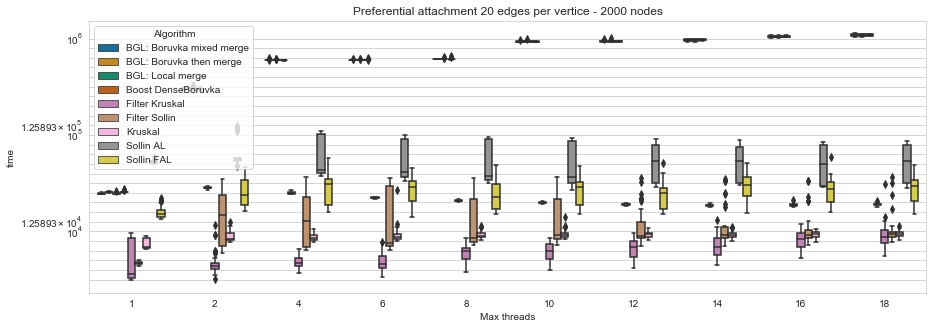

In [11]:
df = df_base

for i, e in enumerate(df.Graph.unique()):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(
        ax=ax, 
        data=df_base[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci=68,
        err_style="bars",
    ).set(yscale="log")
    plt.title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax.set_xticks(2**np.arange(0, 5, 1))
    fig.savefig(f"figures/{dataset}/Graph_runtime_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Graph_runtime_{e[0]}.eps", dpi=450)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(
        ax=ax, 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
    ).set(yscale="log")
    plt.title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    fig.savefig(f"figures/{dataset}/Box_Graph_runtime_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Box_Graph_runtime_{e[0]}.eps", dpi=450)
    plt.show()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


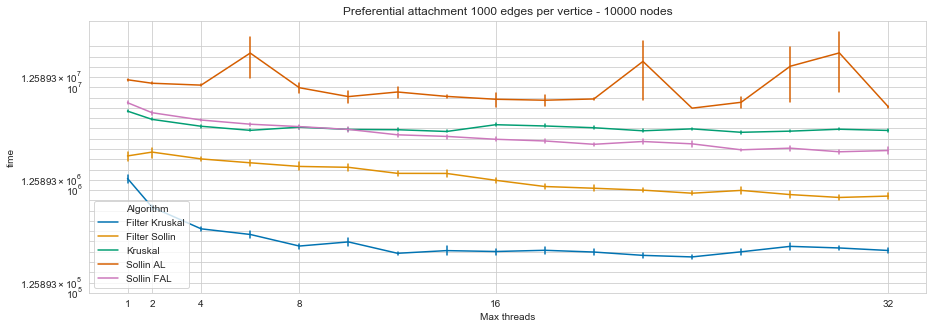

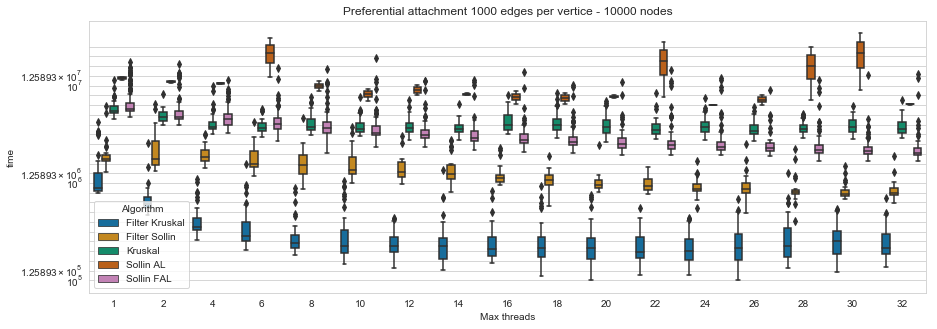

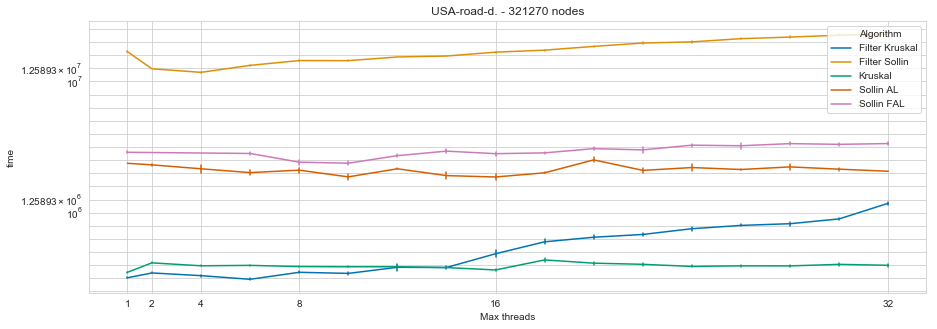

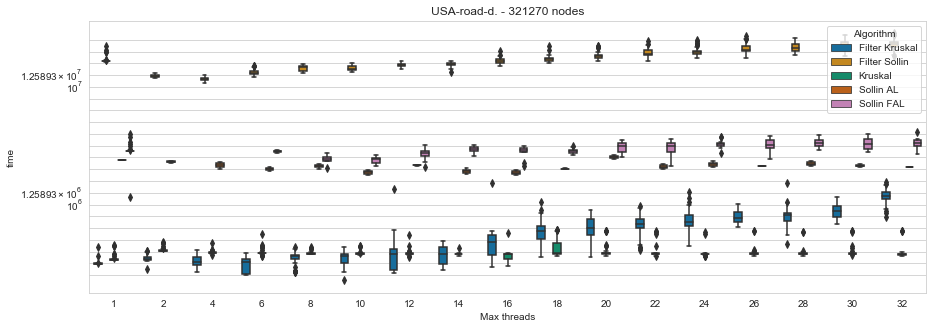

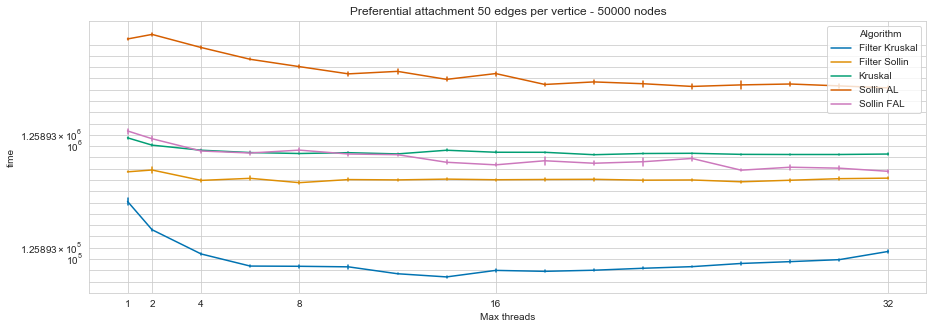

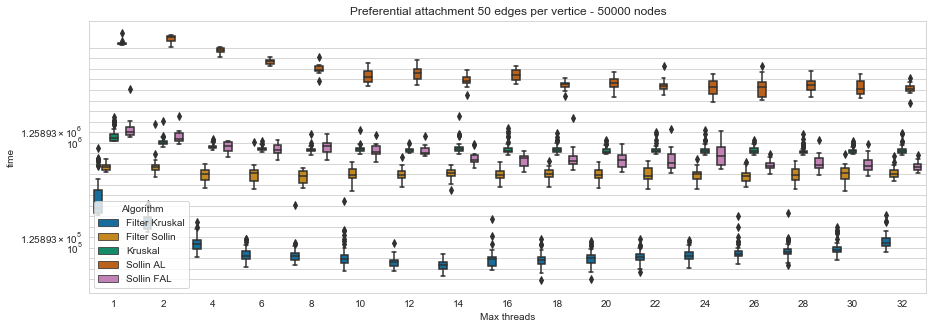

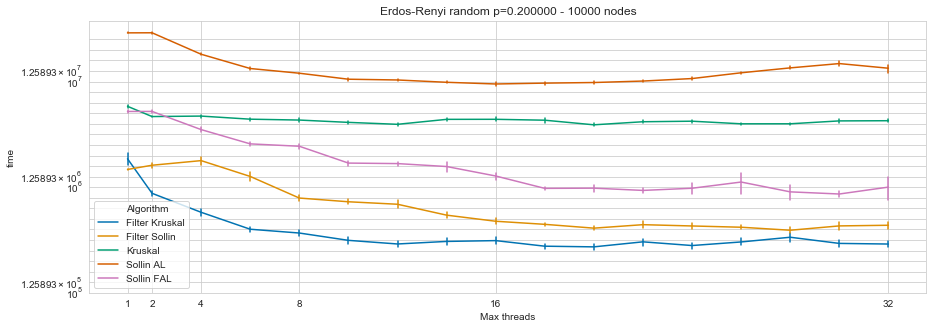

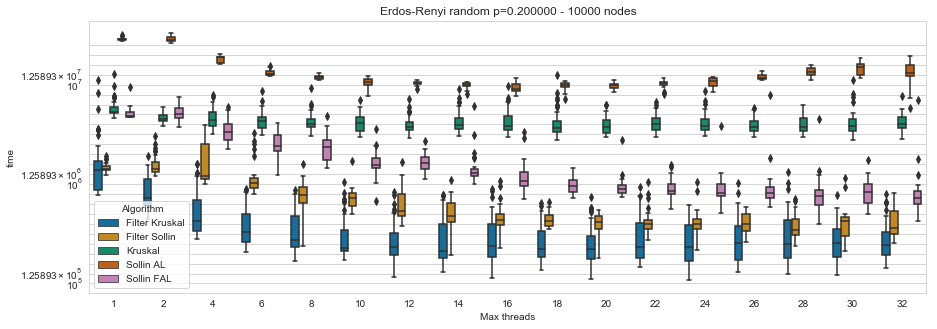

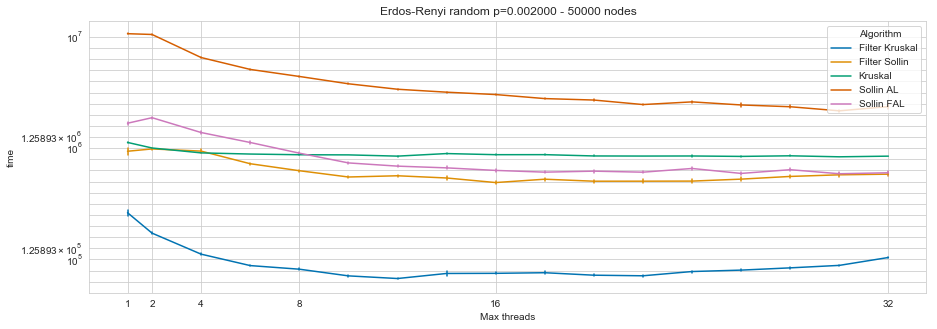

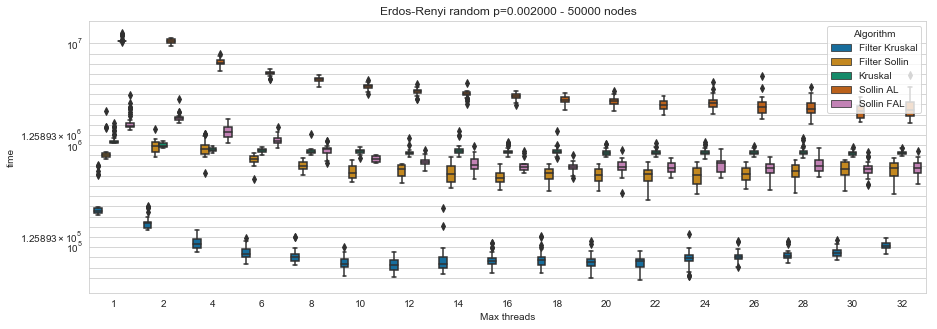

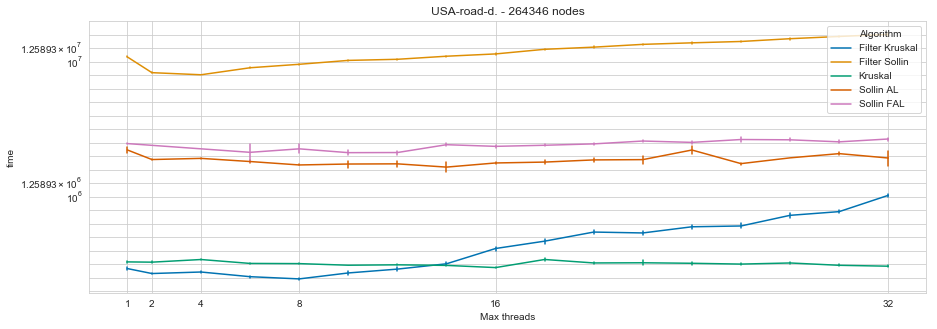

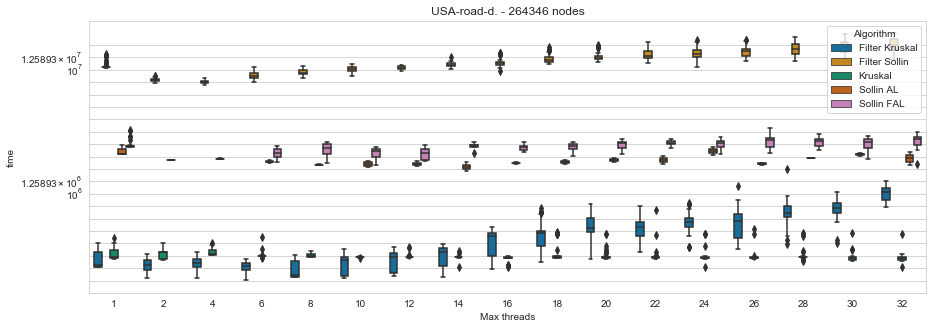

In [12]:
df = df_oth

for i, e in enumerate(df.Graph.unique()):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(
        ax=ax, 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci=68,
        err_style="bars",
    ).set(yscale="log")
    plt.title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax.set_xticks(2**np.arange(0, 6, 1))
    fig.savefig(f"figures/{dataset}/Graph_runtime_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Graph_runtime_{e[0]}.eps", dpi=450)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(
        ax=ax, 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
    ).set(yscale="log")
    plt.title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    fig.savefig(f"figures/{dataset}/Box_Graph_runtime_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Box_Graph_runtime_{e[0]}.eps", dpi=450)
    plt.show()

In [13]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


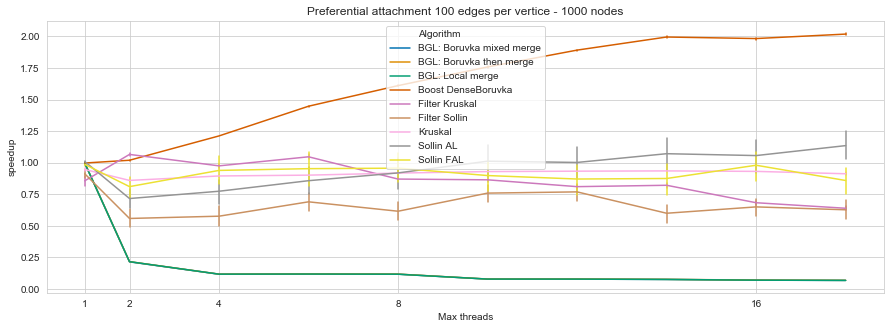

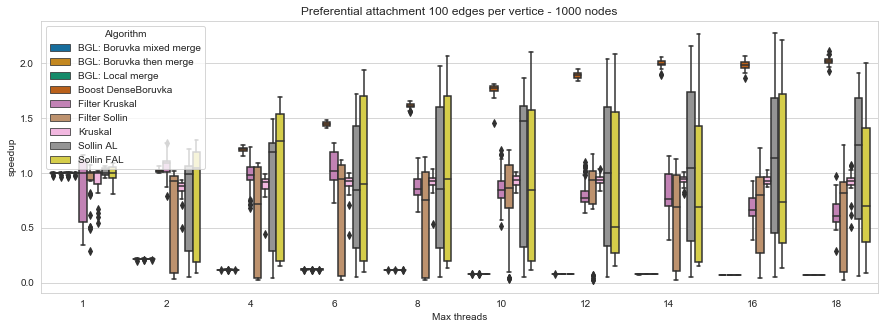

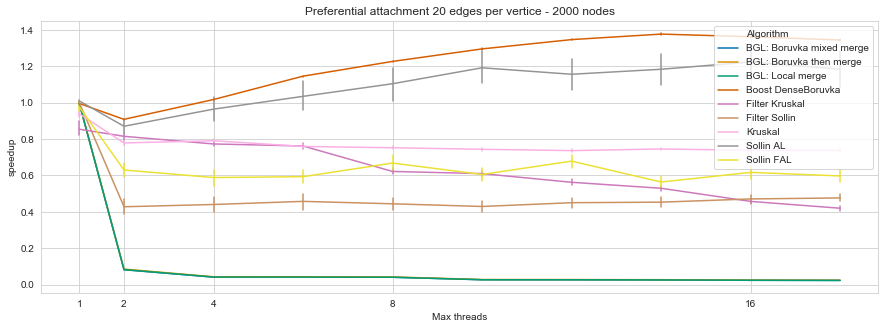

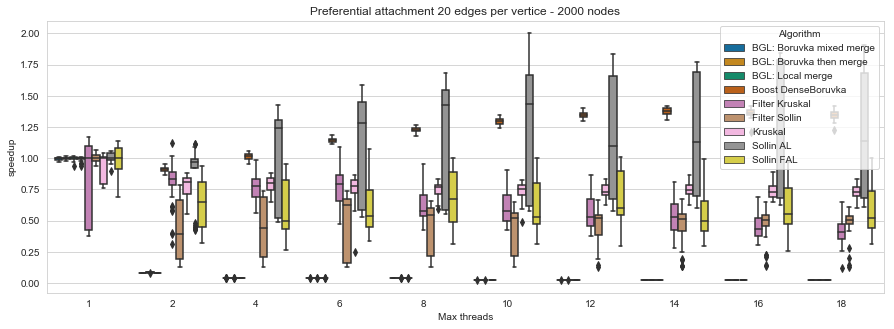

In [14]:
df = df_base

for i, e in enumerate(df.Graph.unique()):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(
        ax=ax, 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        err_style="bars", ci=68,
    )
    ax.set_xticks(2**np.arange(0, 5, 1))
    plt.title(f"{e[0]} - {e[1]} nodes")
    fig.savefig(f"figures/{dataset}/Speedup_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Speedup_{e[0]}.eps", dpi=450)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(
        x="Max threads", y="speedup", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="colorblind", ax=ax
    )
    ax.set_title(f"{e[0]} - {e[1]} nodes")
    plt.title(f"{e[0]} - {e[1]} nodes")
    fig.savefig(f"figures/{dataset}/Box_Speedup_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Box_Speedup_{e[0]}.eps", dpi=450)
    plt.show()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


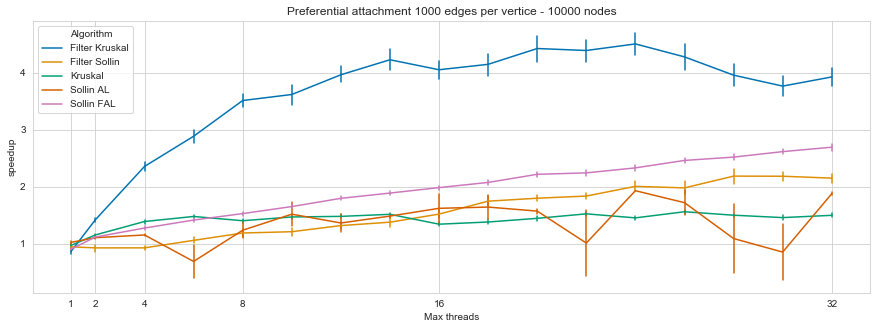

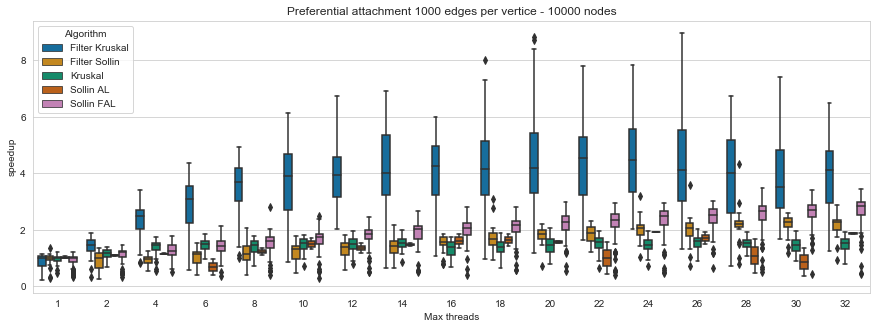

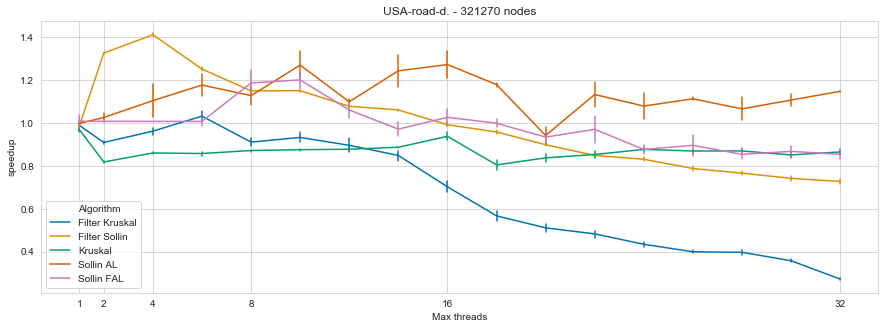

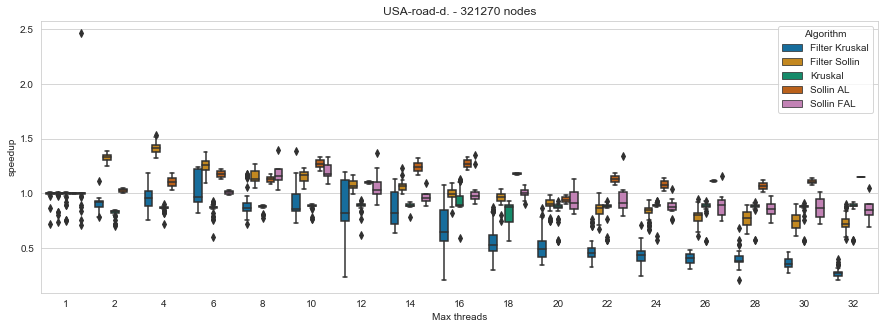

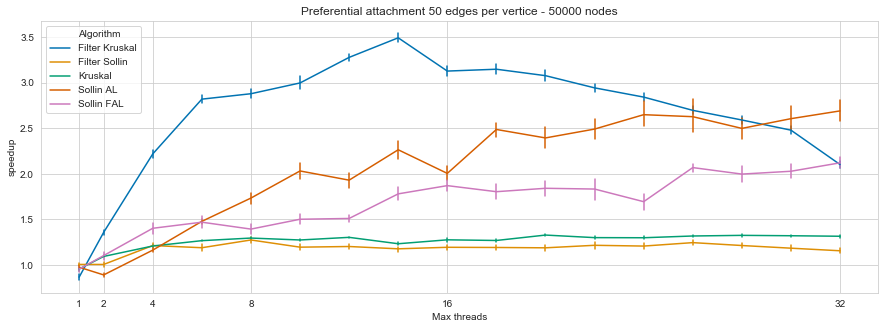

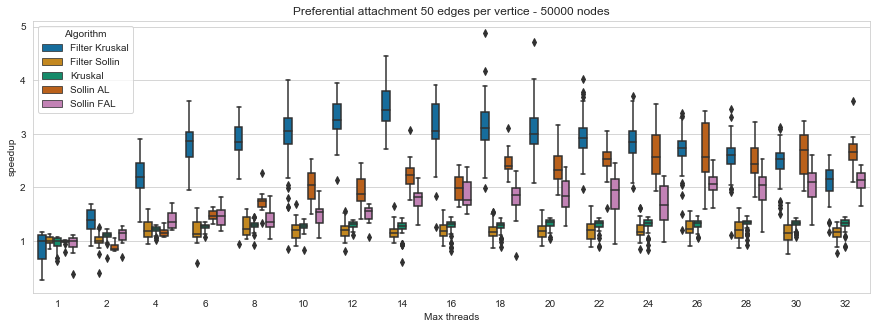

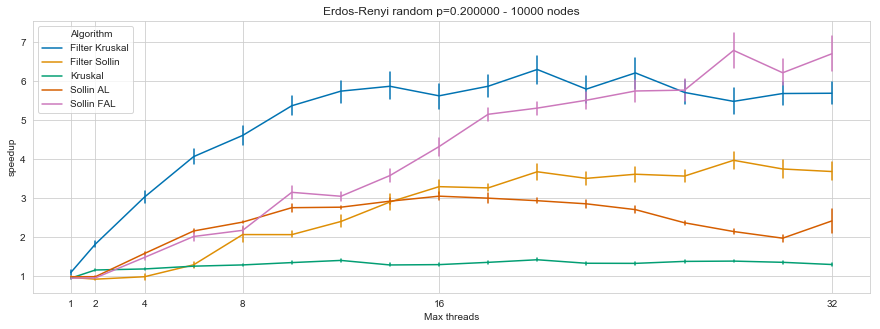

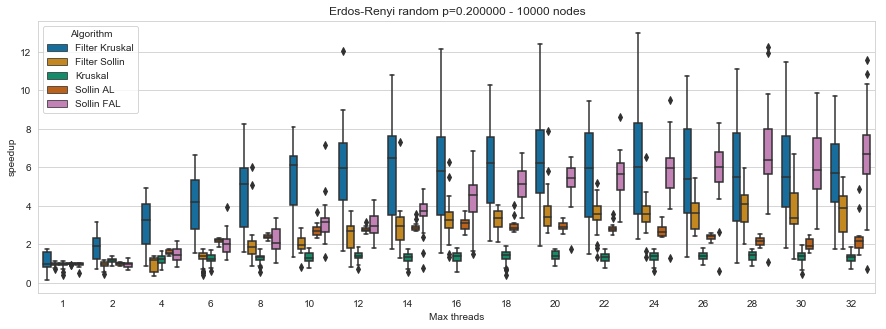

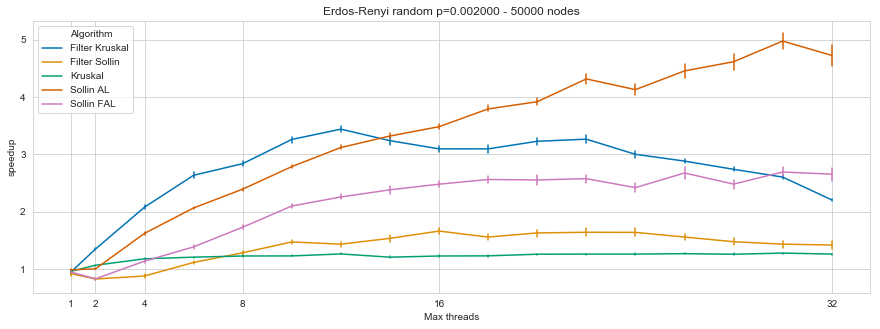

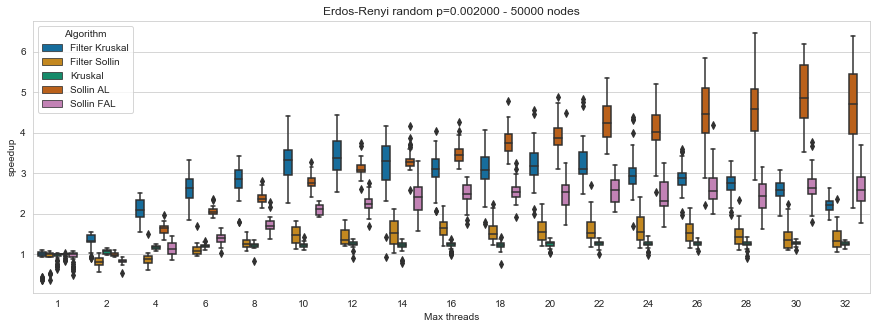

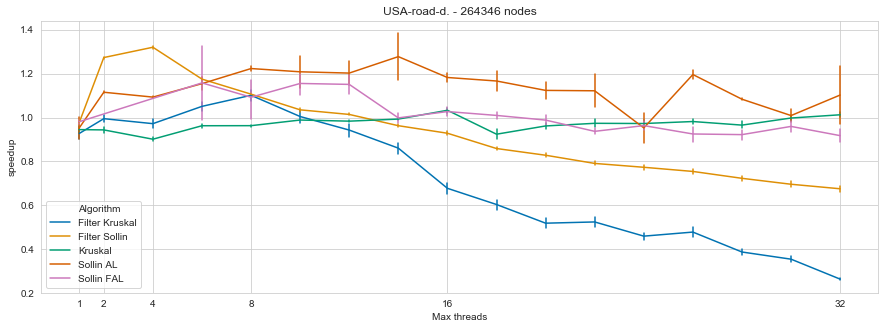

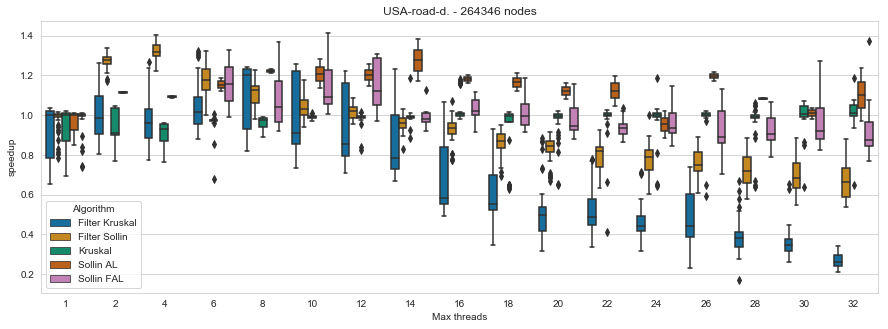

In [15]:
df = df_oth

for i, e in enumerate(df.Graph.unique()):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(
        ax=ax, 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        err_style="bars", ci=68,
    )
    plt.title(f"{e[0]} - {e[1]} nodes")
    ax.set_xticks(2**np.arange(0, 6, 1))
    fig.savefig(f"figures/{dataset}/Speedup_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Speedup_{e[0]}.eps", dpi=450)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(
        x="Max threads", y="speedup", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="colorblind", ax=ax
    )
    ax.set_title(f"{e[0]} - {e[1]} nodes")
    plt.title(f"{e[0]} - {e[1]} nodes")
    fig.savefig(f"figures/{dataset}/Box_Speedup_{e[0]}.png", dpi=450)
    fig.savefig(f"figures/{dataset}/Box_Speedup_{e[0]}.eps", dpi=450)
    plt.show()